In [1]:
import yfinance as yf

from cvx.stat_arb.ccp import *
from backtest import run_portfolio_backtest, run_portfolio_backtest_from_manager
from utils import *
import seaborn as sns
from cvx.covariance.ewma import iterated_ewma, _ewma_cov
from cvx.covariance.combination import from_sigmas
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator, FuncFormatter


sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [2]:
prices_full = pd.read_csv("../data/stock_prices.csv", index_col=0, parse_dates=True)
market_cap = pd.read_csv("../data/market_cap.csv", index_col=0, parse_dates=True).replace(0, np.nan).ffill(limit=1)

spreads = pd.read_csv("../data/spreads_stocks.csv", index_col=0, parse_dates=True)

# handle missing spread data (has no impact on result, but makes backtest easier
# to implement)
rolling_spreads = spreads.rolling(5).mean().ffill().fillna(10 * (0.01**2)).abs()

In [3]:
# only keep assets that are ever top 200 by market cap (we filter out the small
# ones in the backtest anyway)

tradeable_assets = []

for date in prices_full.index:
    top_assets = market_cap.loc[date].nlargest(200)
    tradeable_assets.extend(top_assets.index)

tradeable_assets = list(set(tradeable_assets))

prices_full = prices_full[tradeable_assets]
market_cap = market_cap[tradeable_assets]
spreads = spreads[tradeable_assets]
rolling_spreads = rolling_spreads[tradeable_assets]
rolling_spreads_USD = rolling_spreads * prices_full

### Compute covariances

In [4]:
prices_centered = prices_full - prices_full.rolling(21).mean()

covariance_iterator = iterated_ewma(
    prices_centered,
    125,
    250,
    min_periods_vola=100,
    min_periods_cov=100,
    mean=False,
)

covariances = {}
for covariance in covariance_iterator:
    covariances[covariance.time] = covariance.covariance

covariances = ewma(covariances, halflife=250)


In [5]:
shorting_cost = 0.5 / 100 / 252

(
    results,
    manager,
    portfolio,
    holdings,
    all_weights,
    all_stat_arb_quantities,
    values,
    cashs,
    interest_and_fees,
    trading_costs,
) = run_portfolio_backtest(
    prices_full,
    market_cap,
    rolling_spreads_USD,
    covariances,
    P_max=100,
    moving_midpoint=True,
    midpoint_memory=21,
    T_max=500,
    shorting_cost=shorting_cost,
)

Note: the countdown timer is not accurate


100%|██████████| 3282/3282 [27:18<00:00,  2.00it/s]  


Finished after looking for stat-arbs 133 times


In [21]:
# shorting_cost = 0.5 / 100 / 252

# (
#     results,
#     manager,
#     portfolio,
#     holdings,
#     all_weights,
#     all_stat_arb_quantities,
#     values,
#     cashs,
#     interest_and_fees,
#     trading_costs,
# ) = run_portfolio_backtest_from_manager(
#     manager,
#     prices_full,
#     rolling_spreads_USD, # spreads in USD
#     covariances,
#     shorting_cost=shorting_cost,
# )

Note: the countdown timer is not accurate


100%|██████████| 3282/3282 [08:17<00:00,  6.60it/s] 


### Metrics

In [6]:
# before fees and transaction costs (still takes into account)
# Note: not completely ignoring fees and transaction costs, since
# the "correct" cash account is used when solving the optimization problem

nav_bf = (portfolio.nav).dropna()
rets = nav_bf.pct_change().dropna()

mean = rets.mean() * 252
std = rets.std() * np.sqrt(252)
sharpe = mean / std

print(f"Return: {mean:.2%}")
print(f"Risk: {std:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Drawdown: {compute_drawdowns(nav_bf).max():.2%}")

Return: 21.33%
Risk: 10.33%
Sharpe: 2.07
Drawdown: 11.65%


In [7]:
# after fees and transaction costs

nav_af = portfolio.nav.dropna() + (interest_and_fees - trading_costs).cumsum()
rets = nav_af.pct_change().dropna()

mean = rets.mean() * 252
std = rets.std() * np.sqrt(252)
sharpe = mean / std

print(f"Return: {mean:.2%}")
print(f"Risk: {std:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Drawdown: {compute_drawdowns(nav_af).max():.2%}")

Return: 19.49%
Risk: 12.11%
Sharpe: 1.61
Drawdown: 14.77%


In [36]:
weights = portfolio.weights.dropna()

Mean turnover: 136


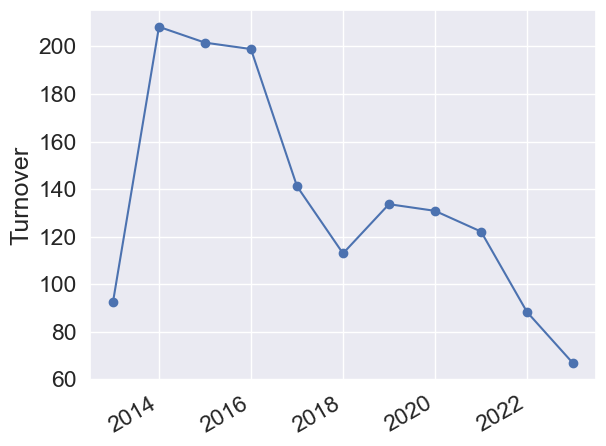

In [82]:
plt.figure()


turnover = 0.5 * weights.diff().abs().sum(axis=1).resample("YE").mean() * 250
plt.plot(turnover, marker="o")
plt.ylabel("Turnover")
print(f"Mean turnover: {turnover.mean():.0f}")
plt.gcf().autofmt_xdate()
plt.tight_layout();




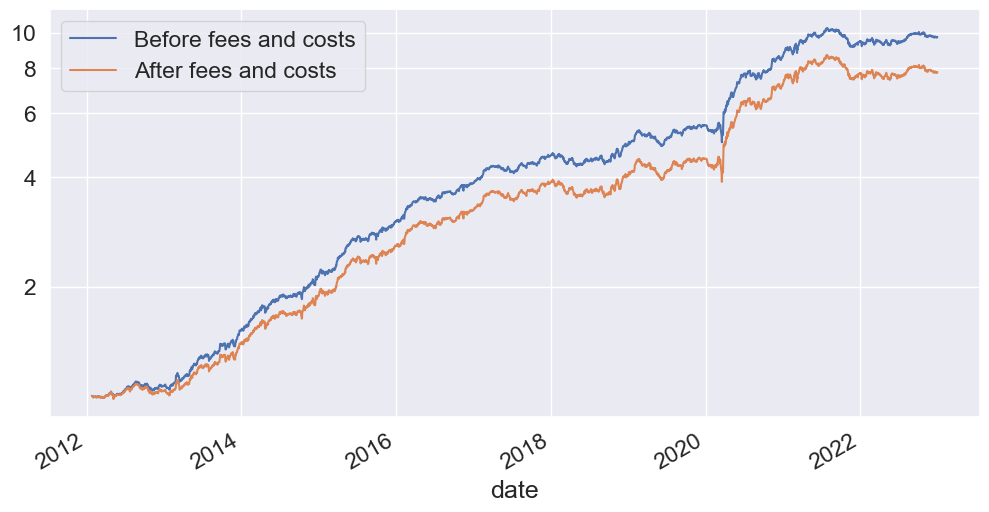

In [24]:
plt.figure(figsize=(12, 6))
nav_bf.plot(label="Before fees and costs")
nav_af.plot(label="After fees and costs")
plt.yscale("log")

y_formatter = ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(y_formatter)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True));
plt.legend();

### Sensitivity analysis

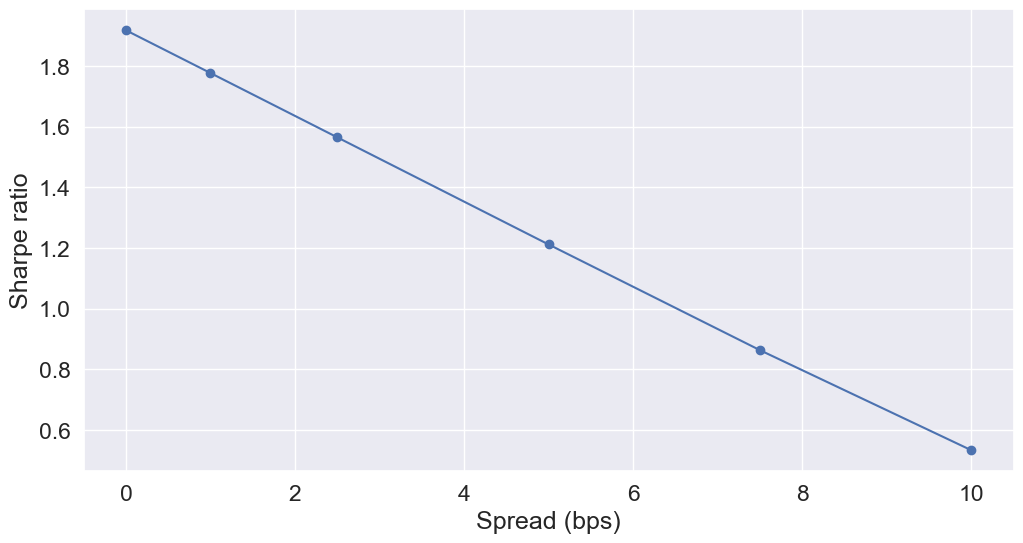

In [160]:
def spread_sensitivity_analysis(portfolio, interest_and_fees, all_spreads):
    sharpes = []
    all_ones = portfolio.prices * 0 + 1

    trades = portfolio.trades_currency

    for s_temp in all_spreads:
        spreads_temp = all_ones * s_temp * (0.01) ** 2

        trading_costs = compute_trading_costs(trades, spreads_temp)
        nav = portfolio.nav + interest_and_fees.cumsum() - trading_costs.cumsum()

        mean = (nav + interest_and_fees.cumsum()).pct_change().mean() * 252
        std = (nav + interest_and_fees.cumsum()).pct_change().std() * np.sqrt(252)
        sharpe = mean / std
        sharpes.append(sharpe)

    return sharpes


all_spreads = [0, 1, 2.5, 5, 7.5, 10]
sharpes = spread_sensitivity_analysis(portfolio, interest_and_fees, all_spreads)

plt.figure(figsize=(12, 6))
plt.plot(all_spreads, sharpes, marker="o")
plt.xlabel("Spread (bps)")
plt.ylabel("Sharpe ratio");

### Compare to market

In [90]:
sp500 = (
    yf.Ticker("^GSPC")
    .history(start="2010-01-01", end="2022-12-30")["Close"]
    .pct_change()
    .dropna()
)

# remove timexone from sp500
sp500.index = sp500.index.tz_localize(None)

In [103]:
merged_index = rets.index.intersection(sp500.index)

sp500 = sp500[merged_index]
rets = rets[merged_index]

mean_sp500 = sp500.mean() * 252
std_sp500 = sp500.std() * np.sqrt(252)
sharpe_sp500 = mean_sp500 / std_sp500

print(f"Market return: {mean_sp500:.2%}")
print(f"Market risk: {std_sp500:.2%}")
print(f"Market Sharpe: {sharpe_sp500:.2f}")

print(f"\nStat-arb correlation with market: {np.corrcoef(sp500, rets)[0, 1]:.1%}")

Market return: 11.31%
Market risk: 17.25%
Market Sharpe: 0.66

Stat-arb correlation with market: 14.6%


In [117]:
active_returns = rets - sp500
mean_active = active_returns.mean() * 252
std_active = active_returns.std() * np.sqrt(252)
active_risk = std_active
print(f"Active return: {mean_active:.2%}")
print(f"Active risk: {std_active:.2%}")

# regress rets on sp500
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False)
reg.fit(sp500.values.reshape(-1, 1), rets.values.reshape(-1, 1))
residual = rets - reg.predict(sp500.values.reshape(-1, 1)).flatten()

alpha = residual.mean() * 252
residual_risk = residual.std() * np.sqrt(252)
print(f"Alpha (residual return): {alpha:.2%}")
print(f"Residual risk: {residual_risk:.2%}")
print(f"Information ratio: {alpha / residual_risk:.2f}")

market_beta = reg.coef_[0, 0]
print(f"Market beta: {market_beta:.3f}")

Active return: 8.23%
Active risk: 19.59%
Alpha (residual return): 18.35%
Residual risk: 12.00%
Information ratio: 1.53
Market beta: 0.105


In [109]:
### annualized alphas and betas
betas = pd.Series(index=rets.index.year.unique(), dtype=float)
alphas = pd.Series(index=rets.index.year.unique(), dtype=float)
residual_risks = pd.Series(index=rets.index.year.unique(), dtype=float)

years = rets.index.year.unique()
for year in years:
    reg = LinearRegression(fit_intercept=False)
    reg.fit(sp500.loc[sp500.index.year == year].values.reshape(-1, 1), rets.loc[rets.index.year == year].values.reshape(-1, 1))
    residual = rets.loc[rets.index.year == year] - reg.predict(sp500.loc[sp500.index.year == year].values.reshape(-1, 1)).flatten()

    alphas[year] = residual.mean() * 252
    betas[year] = reg.coef_[0, 0]
    residual_risks[year] = residual.std() * np.sqrt(252)

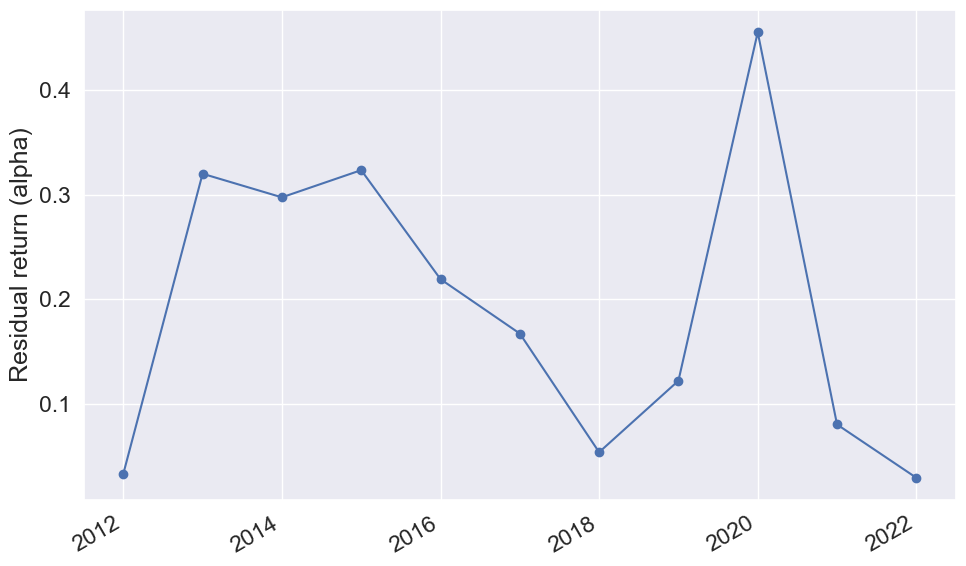

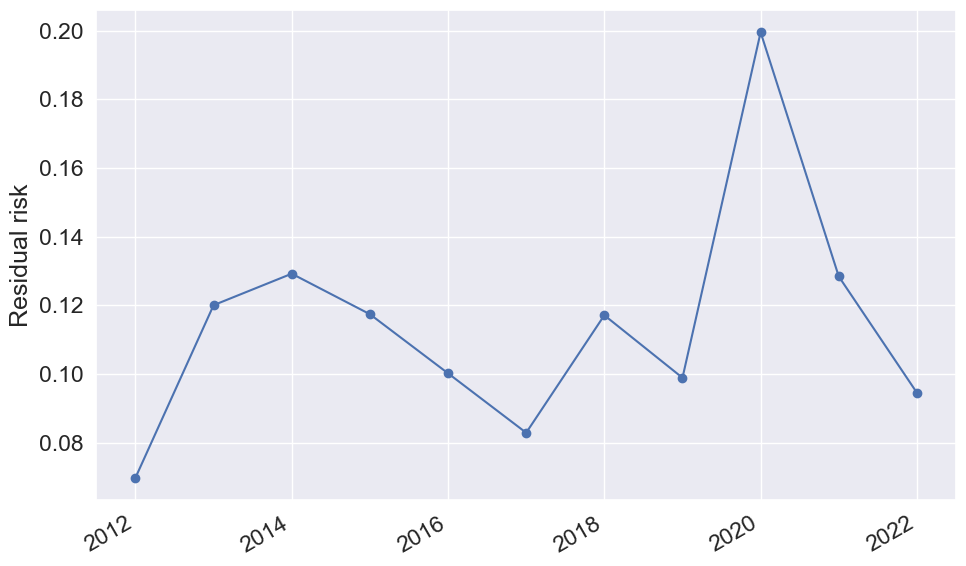

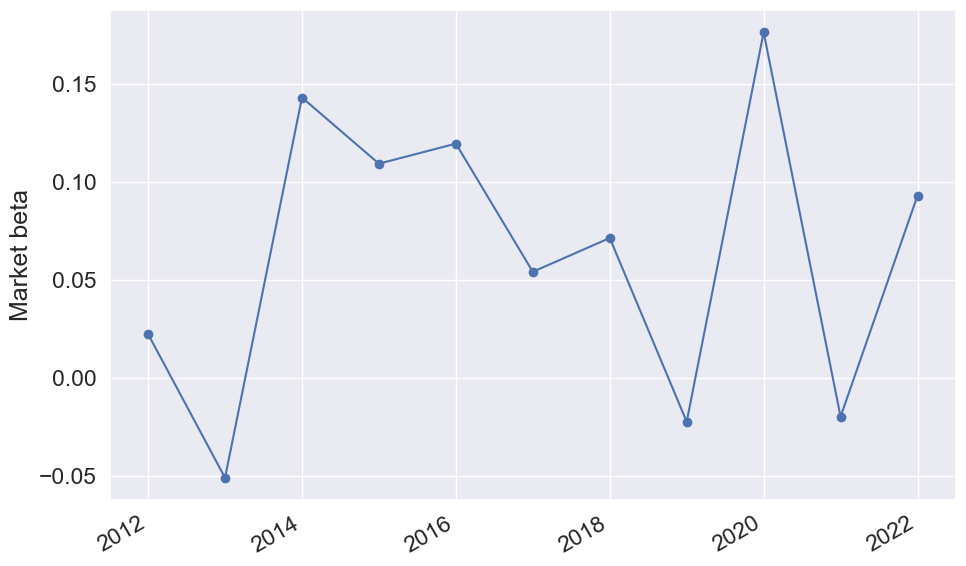

In [110]:
plt.figure(figsize=(10, 6))
alphas.plot(marker="o")
plt.ylabel("Residual return (alpha)")
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.figure(figsize=(10, 6))
residual_risks.plot(marker="o")
plt.ylabel("Residual risk")
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.figure(figsize=(10, 6))
betas.plot(marker="o")
plt.ylabel("Market beta")
plt.gcf().autofmt_xdate()
plt.tight_layout()


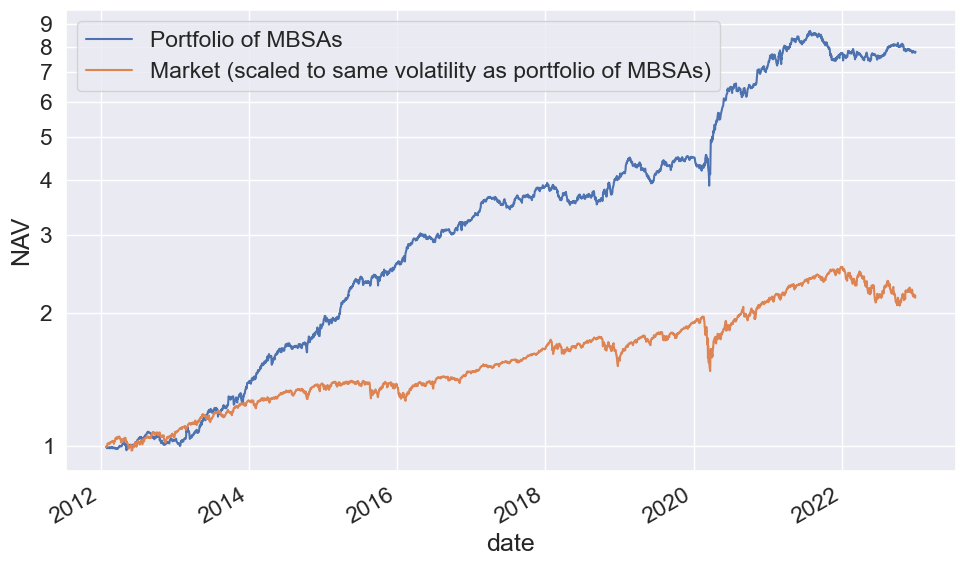

In [120]:
rets = nav_af.pct_change().dropna()

sp500_std = sp500.std() * np.sqrt(252)
stat_arb_std = rets.std() * np.sqrt(252)

factor = stat_arb_std / sp500_std

sp500_scaled = sp500 * factor

plt.figure(figsize=(10, 6))
(1+rets).cumprod().plot(label="Portfolio of MBSAs")
(1+sp500_scaled).cumprod().plot(label="Market (scaled to same volatility as portfolio of MBSAs)")
plt.legend()
plt.yscale("log")
plt.ylabel("NAV")

y_formatter = ScalarFormatter(useOffset=False, useMathText=True)
plt.gca().yaxis.set_major_formatter(y_formatter)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True));
plt.tight_layout();


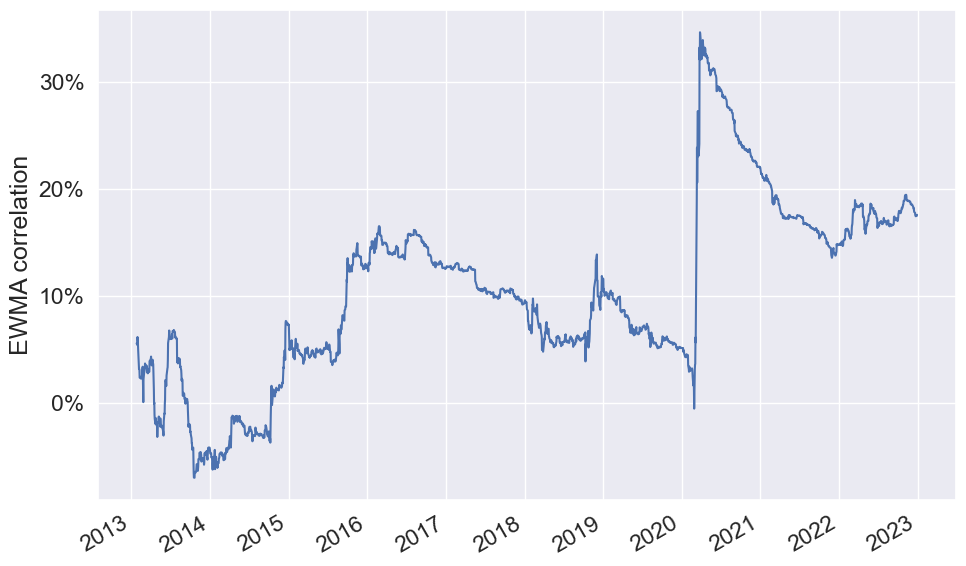

In [121]:
stat_arb_and_sp500 = pd.concat([rets, sp500], axis=1).dropna(axis=0)

corrs = stat_arb_and_sp500.ewm(halflife=250, min_periods=250).corr()

times = corrs.index.get_level_values(0).unique()
ewma_correlations = pd.Series(index=times)

for time in times:
    ewma_correlations[time] = corrs.loc[time].iloc[0, 1]


def to_percent(y, position):
    return "{:.0f}%".format(100 * y)

plt.figure(figsize=(10, 6))
ewma_correlations.plot()
plt.ylabel("EWMA correlation")
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter);
plt.tight_layout();

### Annual metrics

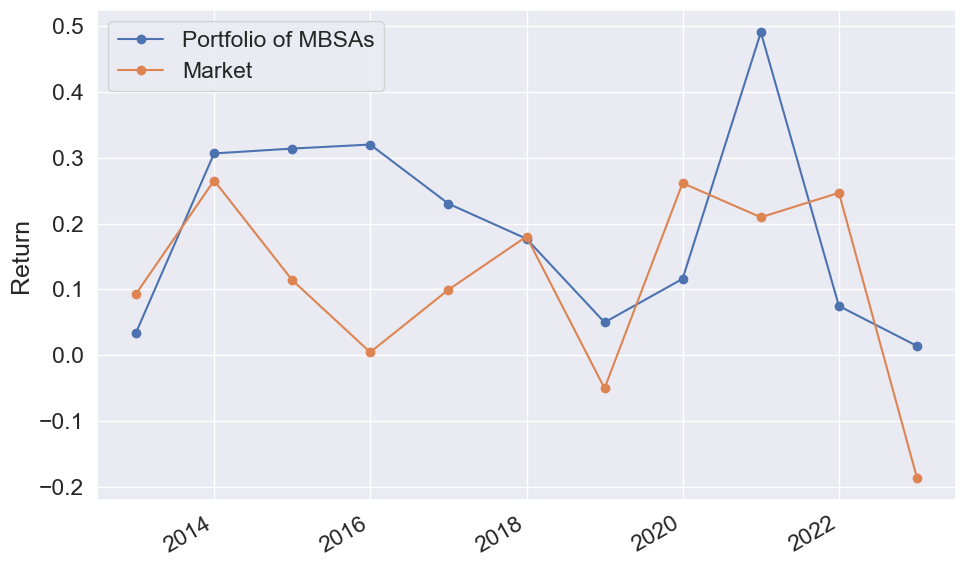

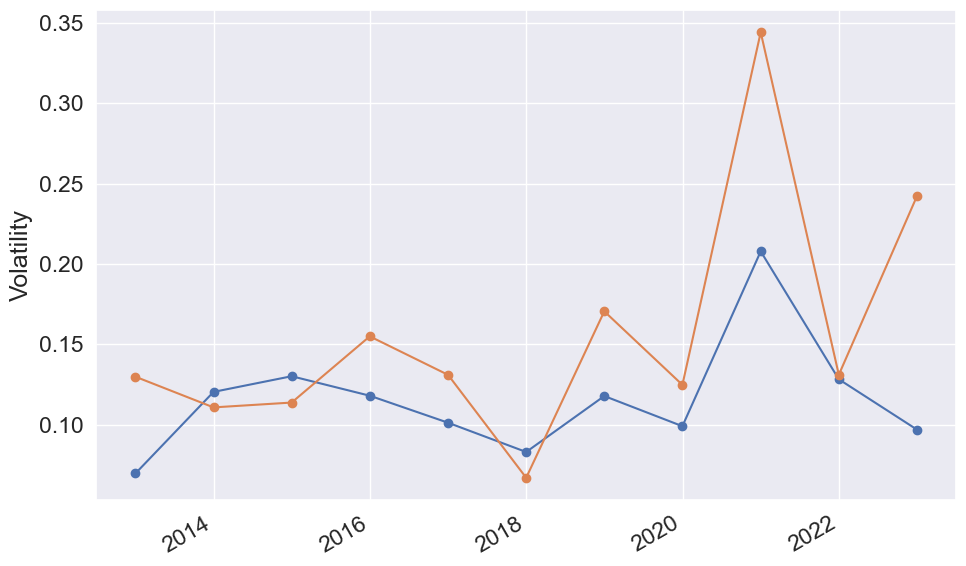

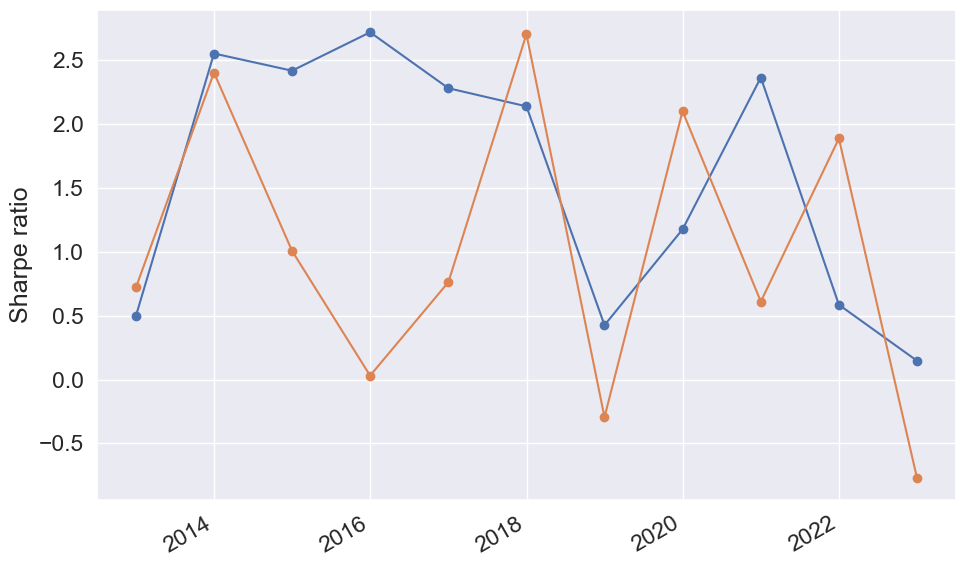

In [77]:
plt.figure(figsize=(10, 6))
yearly_returns = rets.resample("YE").mean() * 252
yearly_returns_sp500 = sp500.resample("YE").mean() * 252
plt.plot(yearly_returns, marker="o")
plt.plot(yearly_returns_sp500, marker="o")
plt.ylabel("Return")
plt.gcf().autofmt_xdate()
plt.legend(["Portfolio of MBSAs", "Market"])
plt.tight_layout();

plt.figure(figsize=(10, 6))
yearly_volatility = rets.resample("YE").std() * np.sqrt(252)
yearly_volatility_sp500 = sp500.resample("YE").std() * np.sqrt(252)
plt.plot(yearly_volatility, marker="o")
plt.plot(yearly_volatility_sp500, marker="o")
plt.ylabel("Volatility")
plt.gcf().autofmt_xdate()

plt.tight_layout();

plt.figure(figsize=(10, 6))
yearly_sharpe = yearly_returns / yearly_volatility
yearly_sharpe_sp500 = yearly_returns_sp500 / yearly_volatility_sp500
plt.plot(yearly_sharpe, marker="o")
plt.plot(yearly_sharpe_sp500, marker="o")
plt.ylabel("Sharpe ratio")
plt.gcf().autofmt_xdate()
plt.tight_layout();

# Additional experiments for fun

### Portfolio 90% stat-arb, 10% market

In [115]:
returns_mixed = 0.9 * rets + 0.1 * sp500

mean_mixed = returns_mixed.mean() * 252
std_mixed = returns_mixed.std() * np.sqrt(252)
sharpe_mixed = mean_mixed / std_mixed

print(f"Return: {mean_mixed:.2%}")
print(f"Risk: {std_mixed:.2%}")
print(f"Sharpe: {sharpe_mixed:.2f}")

Return: 18.72%
Risk: 11.30%
Sharpe: 1.66


In [141]:
### market mix based on rolling correlation

market_mix = ((1-ewma_correlations.dropna())/10)
arb_mix = 1 - market_mix

returns_mixed = arb_mix * rets + market_mix * sp500 
# where returns_mixed is nan, we use rets
returns_mixed = returns_mixed.fillna(sp500)

mean_mixed = returns_mixed.mean() * 252
std_mixed = returns_mixed.std() * np.sqrt(252)
sharpe_mixed = mean_mixed / std_mixed

print(f"Return: {mean_mixed:.2%}")
print(f"Risk: {std_mixed:.2%}")
print(f"Sharpe: {sharpe_mixed:.2f}")

Return: 21.02%
Risk: 12.78%
Sharpe: 1.64


### Mix with bitcoin

In [21]:
# import refinitiv.data as rd
# from refinitiv.data.content import historical_pricing
# from refinitiv.data.content.historical_pricing import Intervals
# from refinitiv.data.content.historical_pricing import Adjustments

In [22]:
# start_date = "2010-01-01"
# end_date = "2024-12-31"

# rd.open_session()
# response_BTC = historical_pricing.summaries.Definition(
#             "BTC="+"CCCL",
#             interval=Intervals.DAILY,
#             start=start_date,
#             end=end_date,
#             adjustments = [
#                 Adjustments.EXCHANGE_CORRECTION,
#                 Adjustments.MANUAL_CORRECTION
#             ],
#         ).get_data()

# price_BTC = response_BTC.data.df.TRDPRC_1.loc[rets.index]
# returns_BTC = price_BTC.pct_change().fillna(0)
# rd.close_session()

In [23]:
# mean_BTC = returns_BTC.mean() * 252
# std_BTC = returns_BTC.std() * np.sqrt(252)
# sharpe_BTC = mean_BTC / std_BTC

# print(f"BTC return: {mean_BTC:.2%}")
# print(f"BTC risk: {std_BTC:.2%}")
# print(f"BTC Sharpe: {sharpe_BTC:.2f}")

# print(f"\nStat-arb correlation with BTC: {np.corrcoef(returns_BTC, rets)[0, 1]:.0%}")

In [24]:
# returns_mixed = 0.9 * rets + 0.05 * returns_BTC + 0.05 * sp500

# mean_mixed = returns_mixed.mean() * 252
# std_mixed = returns_mixed.std() * np.sqrt(252)
# sharpe_mixed = mean_mixed / std_mixed

# print(f"Return: {mean_mixed:.2%}")
# print(f"Risk: {std_mixed:.2%}")
# print(f"Sharpe: {sharpe_mixed:.2f}")

In [25]:
# (1+returns_mixed).cumprod().plot(label="Mixed strategy")
# plt.yscale("log");